# **SPEECH EMOTION RECOGNITION**

## **Data Source :**

We use the dataset available at https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

### **About Dataset**
Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

**Files :**

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.



**File naming convention :**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics - 




**Filename identifiers :**



*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).



**Filename example: "03-01-06-01-02-01-12.wav"**


*   Audio-only (03)
*   Speech (01)
*   Fearful (06)
*   Normal intensity (01)
*   Statement "dogs" (02)
*   1st Repetition (01)
*   12th Actor (12)
Female, as the actor ID number is even.

Mount Google Drive as a file system. It allows access and work with files stored in your Google Drive within the Colab environment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import os, which provides a way to interact with the operating system.

Now, the variable **"Root"** consists of "/content/drive/MyDrive/archive/audio_speech_actors_01-24". This path represents the location of a directory containing audio files.

Then, **"os.chdir(Root)"** changes the current working directory to the directory specified by the Root variable.

In [2]:
import os
Root = "/content/drive/MyDrive/archive/audio_speech_actors_01-24"
os.chdir(Root)

In [3]:
ls

Actor_01/  Actor_05/  Actor_09/  Actor_13/  Actor_17/  Actor_21/
Actor_02/  Actor_06/  Actor_10/  Actor_14/  Actor_18/  Actor_22/
Actor_03/  Actor_07/  Actor_11/  Actor_15/  Actor_19/  Actor_23/
Actor_04/  Actor_08/  Actor_12/  Actor_16/  Actor_20/  Actor_24/


## **Import Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from librosa import display
import soundfile
import os
import glob

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

The sound file with specified path is loaded into the variable **"data"** and the corresponding sampling rate is assigned to the variable **"sampling_rate"**, by using the **librosa.load()** function.

**librosa.display.waveshow()** function is used to displays the waveform of the audio data.

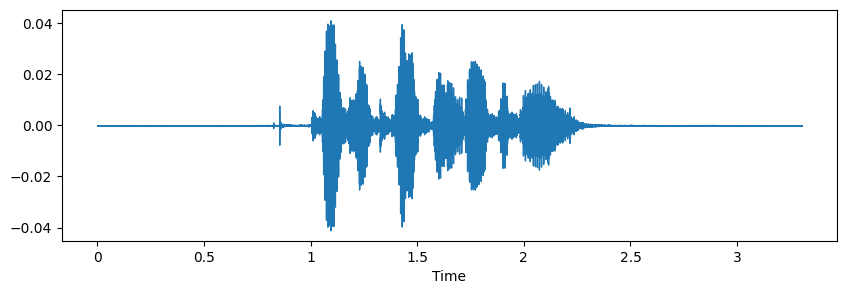

In [5]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/archive/Actor_01/03-01-01-01-01-01-01.wav')    # load sound file & sample rate
plt.figure(figsize=(10, 3))
librosa.display.waveshow(data, sr=sampling_rate)                   # display waveform

Waveform for another sound file.

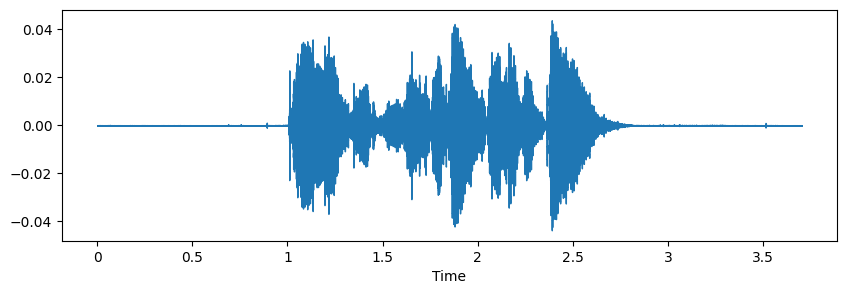

In [6]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/archive/Actor_01/03-01-03-01-02-02-01.wav')    # load sound file & sample rate
plt.figure(figsize=(10, 3))
librosa.display.waveshow(data, sr=sampling_rate)                    # display waveform

Wavwform for another sound file.

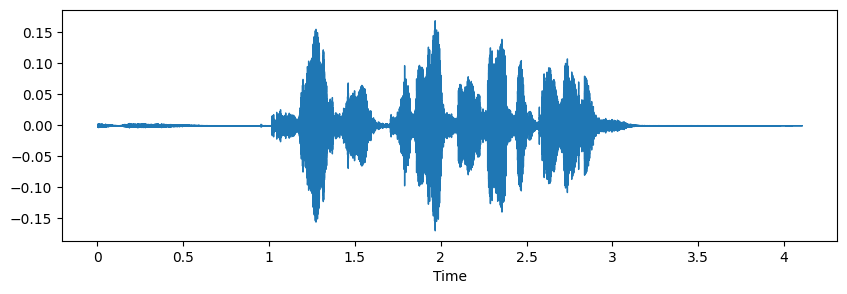

In [8]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/archive/Actor_01/03-01-07-02-01-02-01.wav')    # load sound file & sample rate
plt.figure(figsize=(10, 3))
librosa.display.waveshow(data, sr=sampling_rate)                    # display waveform

### **Feature Extraction**

Now, we extract the features from the sound file.

The function takes four parameters : **file_name, mfcc, chroma, and mel**. These parameters determine which features to extract from the sound file.

The function uses the **soundfile.SoundFile()** context manager to open the sound file specified by **"file_name"**.



*   If **"chroma"** is True, the function calculates the **Short-Time Fourier Transform (STFT)** of the audio signal using librosa.stft(X) and takes the absolute value using **np.abs()**. This is stored in the stft variable.

*   If **"mfcc"** is True, the function calculates the **Mel-frequency Cepstral Coefficients (MFCCs)** using **librosa.feature.mfcc()** and takes the mean across the time axis (axis=0). The resulting MFCCs are stored in the **"mfccs"** variable. The MFCCs are then stacked horizontally with the result array using **np.hstack()**.



*   If **"chroma"** is True, the function calculates the **chroma** feature using **librosa.feature.chroma_stft()** on the stft array and takes the mean across the time axis. The resulting chroma feature is stored in the **"chroma"** variable. The chroma feature is then stacked horizontally with the result array using **np.hstack()**.


*   If **"mel"** is True, the function calculates the **mel spectrogram** using **librosa.feature.melspectrogram()**. The mel spectrogram is then averaged across the time axis, and the result is stored in the **"mel"** variable. The mel spectrogram is then stacked horizontally with the result array using **np.hstack()**.





In [ ]:
# function to extract features from sound file

def extract_feature(file_name, mfcc, chroma, mel):                # mfcc, chroma, mel need to be extracted
    with soundfile.SoundFile(file_name) as sound_file:            # open sound file
        X = sound_file.read(dtype="float32")                      # read sound file
        sample_rate=sound_file.samplerate                         # obtain sample rate 
        if chroma:
            stft=np.abs(librosa.stft(X))                         # if chroma=true, calculate STFT
        result=np.array([])                                 # empty numpy array
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)    # if mfcc=true, calc MFCCs
            result=np.hstack((result, mfccs))                               # store mfccs horizontally in result
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)    # if chroma=true, calc chroma feature
            result=np.hstack((result, chroma))                     # store result horizonatlly in result numpy array
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)      # if mel=true, calc MEl spectrogram
            result=np.hstack((result, mel))                        # store result horizonatlly in result numpy array
    return result                   # return result in array from

Now make a dictionary called **"emotions"** that maps numerical codes to their corresponding emotion labels. Each emotion is associated with a two-digit code, ranging from **'01'** to **'08'**.

The list **"observed_emotions"** contains a selection of emotions that we are interested in observing. It includes the emotions **'calm', 'happy', 'fearful',** and **'disgust'**.

In [ ]:
 # emotions in the RAVDESS dataset

emotions = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad', 
          '05':'angry', '06':'fearful', '07':'disgust','08':'surprised'}


observed_emotions = ['calm', 'happy', 'fearful', 'disgust']               # emotions to observe

Now, we make a function called **"load_data()"** that is used to load the sound files from a specified directory and extract features from them.



*   The function takes an optional parameter **test_size** which determines the proportion of data to be allocated for testing. By default, it is set to 0.2, meaning 20% of the data will be used for testing.

*   Two empty lists x and y are initialized. These lists will store the extracted features (x) and corresponding emotions (y) for each sound file.


*   **"glob.glob()"** function is used to iterate through all the sound files in the specified directory.

*   For each file, the base name of the file is obtained using **"os.path.basename(file)"**. This extracts the filename without the directory path.


*   The emotion of the file is determined by splitting the file name using the **"-"** character and accessing the corresponding emotion from the emotions dictionary. The file name has a specific format where the emotion code is located at the third position when split.

*   The **"extract_feature()"** function is called to extract features from the current sound file.



*   Finally, the function returns the train-test split of the feature and emotion data using **"train_test_split()"** from the **sklearn.model_selection** module. The **"np.array(x)"** represents the feature data, **"y"** represents the emotion data, and **"test_size"** determines the proportion of data allocated for testing. The **random state** is set to **9** for reproducibility.










In [ ]:
# funation to load data & extract features for each sound file

def load_data(test_size=0.2):                            
    x,y = [],[]                                  # empty list to store extracted features & corresponding emotions

    for file in glob.glob("/content/drive/MyDrive/archive/audio_speech_actors_01-24*/*.wav"):        # iterate through all sound file
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]                  # extract the emotion of sound file
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)       # call function to extract (mfcc, mel, chroma) features
        x.append(feature)                             # append features in x
        y.append(emotion)                             # append their corresponding emotion to y
    return train_test_split(np.array(x), y, test_size = test_size, random_state = 9)            # return the train-test-split data

Split the dataset into **training** and **testing** sets using the **"load_data()"** function.

The **load_data()** function is called with the argument **"test_size = 0.25"**

In [ ]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)                      # split the dataset

Let's see the **"x_train"**.

In [ ]:
x_train

array([[-6.02389954e+02,  5.97717743e+01,  8.60734844e+00, ...,
         2.24425294e-05,  7.05290176e-06,  3.74911019e-06],
       [-6.64690369e+02,  6.82226181e+01,  6.91438007e+00, ...,
         1.92348180e-05,  1.16888250e-05,  1.09572538e-05],
       [-5.56770630e+02,  3.49958611e+01, -1.21606884e+01, ...,
         1.56850641e-04,  9.86818704e-05,  6.10335883e-05],
       ...,
       [-6.41358337e+02,  4.56047516e+01,  3.17263484e-01, ...,
         3.32857708e-05,  2.42486913e-05,  1.74304023e-05],
       [-6.41742493e+02,  3.81749878e+01, -8.41347885e+00, ...,
         3.26658337e-05,  2.97957540e-05,  2.17277611e-05],
       [-7.70246155e+02,  3.43720894e+01,  5.50091887e+00, ...,
         4.58828936e-06,  2.15270302e-06,  1.44739533e-06]])

Print the number of samples in the training and testing sets of the dataset.

**"x_train.shape[0]"** returns the number of samples in the training set.

**"x_test.shape[0]"** returns the number of samples in the testing set.

In [ ]:
print((x_train.shape[0], x_test.shape[0]))                         # print shape of x_train and x_test datasets

(576, 192)


Print the number of features that have been extracted from the dataset.

In [ ]:
print(f'Features extracted: {x_train.shape[1]}')                 # number of features extracted

Features extracted: 180


## **Multi-Layer Perceptron**

 First, create an instance of the **"MLPClassifier"** class.



*   **alpha :** It controls the L2 regularization term to prevent overfitting. A smaller value indicates stronger regularization.

*   **batch_size :** It determines the number of samples per gradient update during training.  Here, batch_size --> 256.


*   **epsilon :** It is a small value added to the denominator to avoid division by zero errors during training. Here, epsilon --> 1e-08.

*   **hidden_layer_sizes :** It specifies the number of neurons in each hidden layer. In this case, there is a single hidden layer with **300 neurons**.

*   **learning_rate :** It determines how the learning rate is adapted during training. **'adaptive'** means the learning rate is adjusted based on the validation score.

*   **max_iter :** specifies the maximum number of iterations or epochs for training. Here. max_iter --> 500







In [ ]:
# initialize the multi layer perceptron classifier

model = MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), 
                    learning_rate = 'adaptive', max_iter = 500)

Now, train the model on the training dataset i.e, x_train and y_train.

In [ ]:
model.fit(x_train, y_train)                                # train the model

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Use **"predict()"** function on the trained model to make predictions on the testing dataset i.e, x_test data.

In [ ]:
y_pred = model.predict(x_test)                      # predictions for testing data

Predictions generated by the trained model on the testing data.

In [ ]:
y_pred                         # predictions

array(['calm', 'disgust', 'calm', 'happy', 'calm', 'happy', 'disgust',
       'calm', 'happy', 'fearful', 'calm', 'fearful', 'disgust',
       'fearful', 'fearful', 'calm', 'happy', 'fearful', 'disgust',
       'calm', 'happy', 'happy', 'fearful', 'happy', 'happy', 'calm',
       'disgust', 'calm', 'happy', 'happy', 'happy', 'calm', 'happy',
       'happy', 'fearful', 'calm', 'disgust', 'calm', 'happy', 'disgust',
       'calm', 'disgust', 'happy', 'happy', 'calm', 'fearful', 'calm',
       'fearful', 'calm', 'happy', 'happy', 'disgust', 'fearful', 'calm',
       'fearful', 'happy', 'fearful', 'disgust', 'disgust', 'calm',
       'happy', 'fearful', 'disgust', 'fearful', 'fearful', 'calm',
       'happy', 'happy', 'calm', 'happy', 'fearful', 'calm', 'calm',
       'calm', 'disgust', 'calm', 'fearful', 'happy', 'happy', 'disgust',
       'happy', 'fearful', 'fearful', 'fearful', 'calm', 'calm', 'calm',
       'disgust', 'happy', 'calm', 'happy', 'calm', 'calm', 'fearful',
       'calm',

Now, calculate the accuracy of the model by comparing the original results with the predictions. Then store it into the **"accuracy"** variable.

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)             # calculate accuracy of model

Print the accuracy of the model.

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy*100))                      # print accuracy

Accuracy: 73.44%


Here, the accuracy of the model is **73.44%** which can be increased by hyperparameter tuning.

Now, calculate the **F1 score** for each class in a multi-class classification problem.

In [ ]:
f1_score(y_test, y_pred,average=None)                         # calculate f1-score

array([0.8173913 , 0.65822785, 0.70967742, 0.72164948])

Create a new dataframe named **"df"** which consists of two columns i.e, **"Actual"** and **"Predicted"**.

"Actual" consists of the original emotions of the sound files.
"Predicted" consists of the predicted emotions generated by the model.


In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})                    # new dataframe 
df.head(20)

,Actual,Predicted
0,calm,calm
1,disgust,disgust
2,calm,calm
3,happy,happy
4,happy,calm
5,happy,happy
6,disgust,disgust
7,disgust,calm
8,happy,happy
9,fearful,fearful
